# Lecture 14. Intro to iterative methods

## Previous lecture

- Direct methods for LU
- Graph separators

# The main topics for today

Concept of **iterative methods** for linear systems: 
- Richardson iteration and its convergence
- Chebyshev iteration

# Iterative methods

- If we want to achieve $\mathcal{O}(N)$ complexity of solving sparse linear systems, then direct solvers are not appropriate.

- If we want to solve partial eigenproblem, the full eigendecomposition is too costly.

- For both problems we will use iterative, Krylov subspace solvers, which treat the matrix as a **black-box** linear operator.

## Matrix as a black box

- We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  
and this action can be computed in $\mathcal{O}(N)$ operations.

- **This is the only information** we know about the matrix: the <span style='color:red'> matrix-by-vector product (matvec) </span>

- Can we solve linear systems using only matvecs?

- Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Connection to ODEs

- The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


- Consider a time-dependent problem 

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

- Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{y_{k+1} - y_k}{\tau} = -A y_k + f.$$

which leads to the Richardson iteration

$$
    y_{k+1} = y_k - \tau(Ay_k -f)
$$

## Convergence of the Richardson method

- Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ in any norm, the iteration converges. 

- For symmetric positive definite case it is always possible to select $\tau$ such that the method converges.

- What about the non-symmetric case? Below demo will be presented...

## Optimal parameter choice

- The choise of $\tau$ that minimizes $\|I - \tau A\|_2$ for $A = A^* > 0$ is (prove it!)

$$
  \tau_\mathrm{opt} = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

- So, to find optimal parameter, we need to know the **bounds of the spectrum** of the matrix $A$, and we can compute it by using **power method**.

## Condition number and convergence speed

Even with the optimal parameter choice, the error at the next step satisfies

$$\|e_{k+1}\|_2 \leq q \|e_k\|_2 , \quad\rightarrow \quad \|e_k\|_2 \leq q^{k} \|e_0\|_2,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1},
$$

$$\mathrm{cond}(A) = \frac{\lambda_{\max}}{\lambda_{\min}} \quad \text{for} \quad A=A^*>0$$

is the condition number of $A$.

Let us do some demo...

Maximum eigenvalue = 3.9848410193438957, minimum eigenvalue = 0.0037933425259120556
Condition number = 1050.482784542584
Theoretical factor: 0.9980979241606224


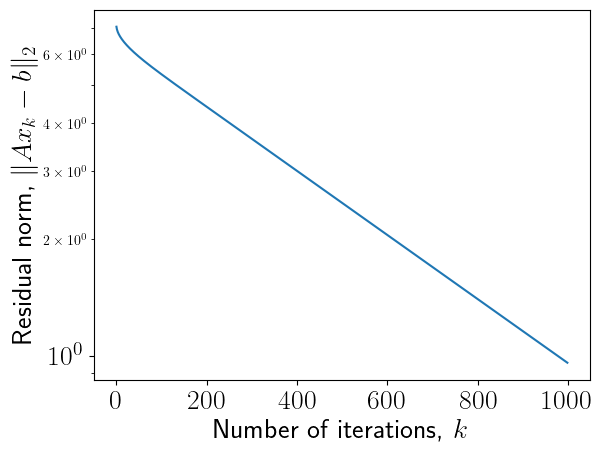

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 50
ex = np.ones(n);
A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 1000
x = np.zeros(n)
res_richardson = []
for i in range(niters):
    rr = A.dot(x) - rhs
    x = x - tau_opt * rr
    res_richardson.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_richardson)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print("Maximum eigenvalue = {}, minimum eigenvalue = {}".format(lam_max, lam_min))
cond_number = lam_max.real / lam_min.real
print("Condition number = {}".format(cond_number))
#print(np.array(res_richardson)[1:] / np.array(res_richardson)[:-1])
print("Theoretical factor: {}".format((cond_number - 1) / (cond_number + 1)))

- Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.<br>
- This is another reason why **condition number** is so important:

    * Besides  the bound on the error in the solution, it also gives an estimate of the number of iterations for the iterative methods.

- Main questions for the iterative method is how to make the matrix **better conditioned**.
- The answer is <span style='color:red'> use preconditioners</span>. Preconditioners will be discussed in further lectures.

### Consider non-hermitian matrix $A$

Possible cases of Richardson iteration behaviour:
- convergence
- divergence
- almost stable trajectory

**Q:** how can we identify our case **before** running iterative method?

In [4]:
# B = np.random.randn(2, 2)
B = np.array([[1, 2], [-1, 0]])
# B = np.array([[0, 1], [-1, 0]])
x_true = np.zeros(2)
f = B.dot(x_true)
eigvals = np.linalg.eigvals(B)
print("Spectrum of the matrix = {}".format(eigvals))

# Run Richardson iteration
x = np.array([0, -1])
tau = 1e-2
conv_x = [x]
r = B.dot(x) - f
conv_r = [np.linalg.norm(r)]
num_iter = 1000
for i in range(num_iter):
    x = x - tau * r
    conv_x.append(x)
    r = B.dot(x) - f
    conv_r.append(np.linalg.norm(r))

Spectrum of the matrix = [0.5+1.32287566j 0.5-1.32287566j]


Text(0, 0.5, 'Residual norm')

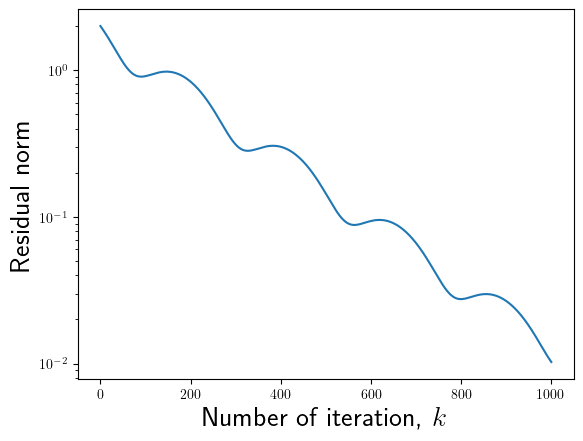

In [5]:
plt.semilogy(conv_r)
plt.xlabel("Number of iteration, $k$", fontsize=20)
plt.ylabel("Residual norm", fontsize=20)

Text(0.5, 1.0, '$x_0 = (0, -1)$')

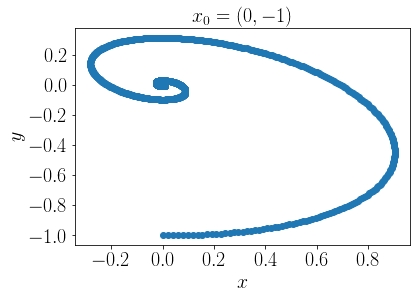

In [8]:
plt.scatter([x[0] for x in conv_x], [x[1] for x in conv_x])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("$x_0 = (0, -1)$", fontsize=20)

## Better iterative methods

But before preconditioners, we can use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: The steepest descent method

- Suppose we **change** $\tau$ every step, i.e. 

$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$

- A possible choice of $\tau_k$ is such that it minimizes norm of the current residual

$$ \tau_k = \arg\min_{\tau} \|A(x_k - \tau_k (A x_k - f)) - f\|_2^2.$$

- This problem can be solved analytically (derive this solution!)

$$ \tau_k = \frac{r_k^{\top}r_k}{r_k^{\top}Ar_k}, \quad r_k = Ax_k - f $$

- This method is called **the steepest descent**.

- However, it still converges similarly to the Richardson iteration.

## Attempt 2: Chebyshev iteration

Another way to find $\tau_k$ is to consider

$$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$

and hence

$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$

where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ 

over all possible polynomials $p(x)$ of degree $k+1$ such that $p(0)=1$. We will use $\|\cdot\|_2$.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_i |p(\lambda_i)| \overset{!}{\leq}
\max_{\lambda_\min \leq \lambda {\leq} \lambda_\max} |p(\lambda)|.$$

The latter inequality is the only approximation. Here we make a <span style='color:red'> crucial assumption </span> that we do not want to benefit from distribution of spectra between $\lambda_\min$ and $\lambda_\max$.

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on $[\lambda_\min, \lambda_\max]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[\lambda_\min, \lambda_\max]$ to the interval $[-1, 1]$:

$$
\xi = \frac{{\lambda_\max + \lambda_\min - (\lambda_\min-\lambda_\max)x}}{2}, \quad x\in [-1, 1].
$$

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$.

## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! 

2. We can express $T_n$ from $T_{n-1}$ and $T_{n-2}$: 

$$T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x), \quad T_0(x)=1, \quad T_1(x)=x$$

3. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

4. It has $(n+1)$ **alternation points**, where the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**) (Chebyshev alternance theorem, no proof here).

5. The **roots** are just 

$$n \arccos x_k = \frac{\pi}{2} + \pi k, \quad \rightarrow\quad x_k = \cos \frac{\pi(2k + 1)}{2n}, \; k = 0, \ldots,n-1$$

We can plot them...

Text(0.5, 1.0, 'Interval $x\\in[-1.1, 1.1]$')

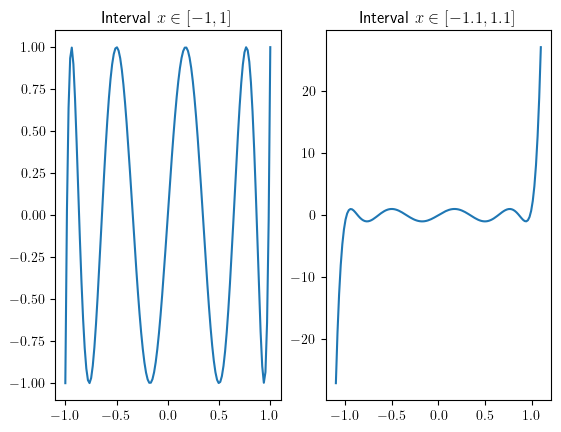

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x1 = np.linspace(-1, 1, 128)
x2 = np.linspace(-1.1, 1.1, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x1, p(x1))
ax1.set_title('Interval $x\in[-1, 1]$')
ax2.plot(x2, p(x2))
ax2.set_title('Interval $x\in[-1.1, 1.1]$')

## Convergence of the Chebyshev-accelerated Richardson iteration

Note that $p(x) = (1-\tau_n x)\dots (1-\tau_0 x)$, hence roots of $p(x)$ are $1/\tau_i$ and that we additionally need to map back from $[-1,1]$ to $[\lambda_\min, \lambda_\max]$.
This results into 

$$\tau_i = \frac{2}{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x_i}, \quad x_i = \cos \frac{\pi(2i + 1)}{2n}\quad i=0,\dots,n-1$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq C q^k e_0, \quad q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1},
$$

which is better than in the Richardson iteration.

[2.50622630e-01 2.50924658e-01 2.51530169e-01 2.52442095e-01
 2.53664865e-01 2.55204461e-01 2.57068471e-01 2.59266178e-01
 2.61808653e-01 2.64708878e-01 2.67981890e-01 2.71644951e-01
 2.75717745e-01 2.80222614e-01 2.85184826e-01 2.90632893e-01
 2.96598938e-01 3.03119118e-01 3.10234126e-01 3.17989766e-01
 3.26437629e-01 3.35635888e-01 3.45650225e-01 3.56554925e-01
 3.68434169e-01 3.81383570e-01 3.95511991e-01 4.10943730e-01
 4.27821135e-01 4.46307759e-01 4.66592186e-01 4.88892691e-01
 5.13462953e-01 5.40599097e-01 5.70648426e-01 6.04020340e-01
 6.41200067e-01 6.82766079e-01 7.29412363e-01 7.81977158e-01
 8.41480389e-01 9.09172947e-01 9.86602291e-01 1.07570085e+00
 1.17890673e+00 1.29933105e+00 1.44099335e+00 1.60915915e+00
 1.81083297e+00 2.05549470e+00 2.35622630e+00 2.73148428e+00
 3.20797673e+00 3.82550533e+00 4.64546321e+00 5.76650218e+00
 7.35516474e+00 9.71018736e+00 1.34098577e+01 1.96891165e+01
 3.15513749e+01 5.76947930e+01 1.29218671e+02 3.40581915e+02]


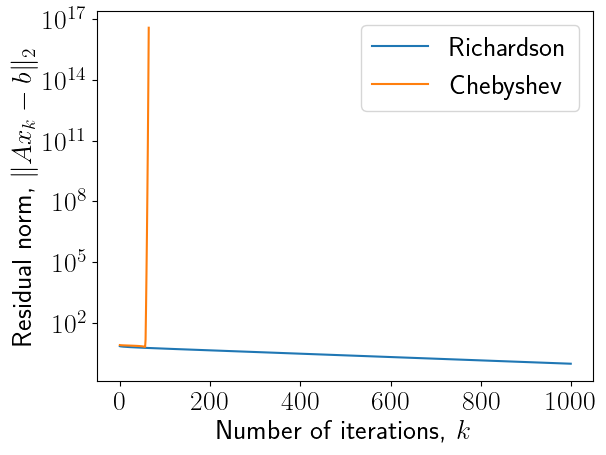

In [11]:
import numpy as np
import matplotlib.pyplot as plt

n = 64
ex = np.ones(n);

A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

niters = 64
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb = [np.linalg.norm(r)]

print(1/np.array(taus))

for i in range(niters):
    x = x - 1.0 / taus[i] * r
    r = A.dot(x) - rhs
    res_cheb.append(np.linalg.norm(r))
    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

### What happened with great Chebyshev iterations?

[ 0 63 31 32 15 48 16 47  7 56 24 39  8 55 23 40  3 60 28 35 12 51 19 44
  4 59 27 36 11 52 20 43  1 62 30 33 14 49 17 46  6 57 25 38  9 54 22 41
  2 61 29 34 13 50 18 45  5 58 26 37 10 53 21 42] 64


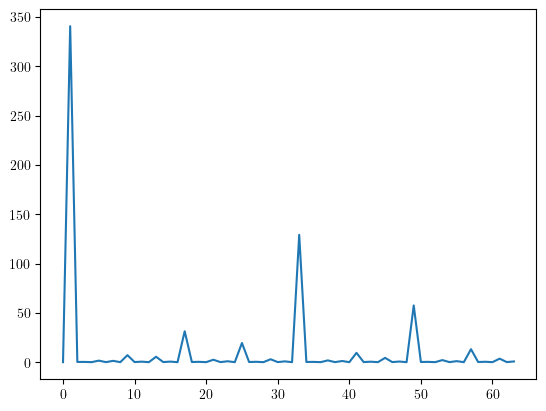

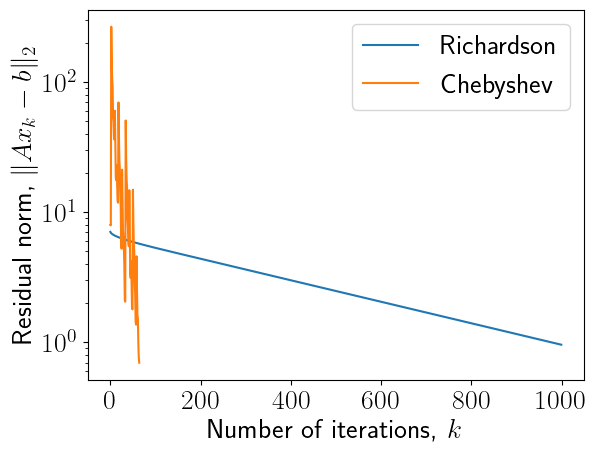

In [16]:
niters = 64
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb_even = [np.linalg.norm(r)]
#print(taus)

# Implementation may be non-optimal if number of iterations is not power of two
def leb_shuffle_2n(n):
    if n == 1:
        return np.array([0,], dtype=int)
    else:
        prev = leb_shuffle_2n(n // 2)
        ans = np.zeros(n, dtype=int)
        ans[::2] = prev
        ans[1::2] = n - 1 - prev
        return ans

good_perm_even = leb_shuffle_2n(niters)
print(good_perm_even, len(good_perm_even))
# good_perm_even = np.random.permutation([i for i in range(niters)])
ts = np.array(taus)[good_perm_even]
plt.figure()
plt.plot(1/ts)
for i in range(niters):
    x = x - 1.0/taus[good_perm_even[i]] * r
    r = A.dot(x) - rhs
    res_cheb_even.append(np.linalg.norm(r))
plt.figure()
    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb_even, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

- Permutation of roots of Chebyshev polynomial has crucial effect on convergence
- On the optimal permutation you can read in paper (V. Lebedev, S. Finogenov 1971)  ([ru](http://www.mathnet.ru/links/42ab1a270ad179d43359ef8fab53422c/zvmmf6870.pdf), [en](https://www.sciencedirect.com/science/article/abs/pii/0041555371901698?via%3Dihub))

### [Chebfun](http://www.chebfun.org/) project

- Opensource project for numerical computing ([Python](https://github.com/chebpy/chebpy) and [Matlab](https://github.com/chebfun/chebfun) interfaces)
- It is based on numerical algorithms working with piecewise polynomial interpolants and Chebyshev polynomials
- This project was initiated by Nick Trefethen and his student Zachary Battles in 2002, see [paper on chebfun project in SISC](http://www.chebfun.org/publications/chebfun_paper.pdf)
- Chebfun toolbox focuses mostly on the following problems
    - Approximation
    - Quadrature
    - ODE
    - PDE
    - Rootfinding
    - 1D global optimization

## Beyond Chebyshev

- We have made an important assumption about the spectrum: it is contained within an interval over the real line (and we need to know the bounds)

- If the spectrum is contained within **two intervals**, and we know the bounds, we can also put the optimization problem for the **optimal polynomial**.

## Spectrum of the matrix contained in multiple segments

- For the case of **two segments** the best polynomial is given by **[Zolotarev polynomials](https://www.encyclopediaofmath.org/index.php/Zolotarev_polynomials)** (expressed in terms of elliptic functions). Original paper was published in 1877, see details [here](http://gpntb.dlibrary.org/ru/nodes/4245-zolotarev-e-prilozhenie-ellipticheskih-funktsiy-k-voprosam-o-funktsiyah-naimenee-i-naibolee-otklonyayuschihsya-ot-nulya-spb-1877) 

- For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

## How can we make it better

- The implementation of the Chebyshev acceleration requires the knowledge of the spectrum.

- It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

- It belongs to the class of **two-term** iterative methods, i.e. it approximates $x_{k+1}$ using 2 vectors: $x_k$ and $r_k$.

- It appears that if we **store more vectors**, then we can go without the spectrum estimation (and better convergence in practice)!

## Crucial point: Krylov subspace

The Chebyshev method produces the approximation of the form

$$x_{k+1} = x_0 + p(A) r_0,$$

i.e. it lies in the **Krylov subspace** of the matrix  which is defined as

$$
   \mathcal{K}_k(A, r_0) = \mathrm{Span}(r_0, Ar_0, A^2 r_0, \ldots, A^{k-1}r_0 )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 
certain **norm of the error**

## Idea of Krylov methods

The idea is to minimize given functional:
- Energy norm of error for systems with hermitian positive-definite matrices (CG method).
- Residual norm for systems with general matrices (MINRES and GMRES methods).
- Rayleigh quotient for eigenvalue problems (Lanczos method).

To make methods practical one has to 
1. Orthogonalize vectors $A^i r_0$ of the Krylov subspace for stability (Lanczos process).
2. Derive recurrent formulas to decrease complexity.

We will consider these methods in details on the next lecture.

## Take home message

- Main idea of iterative methods
- Richardson iteration: hermitian and non-hermitian case
- Chebyshev acceleration
- Definition of Krylov subspace

### Questions?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()